In [1]:
from chyk import *
handcalcs.set_option("param_columns", 2)
from math import degrees as r2d
from math import radians as d2r
rho = 1.21  # $\frac{kg}{m^3}$, air density
g = 9.81  # $\frac{m}{s^2}$
from pathlib import Path

In [11]:
base = Path("data")
door_df = pd.read_csv(base / "doordash.csv")
uber_df = pd.read_csv(base / "ubereats.csv")

def decumulate(df):
    df = df.copy()
    # yr stuff
    yymm = df["YYMM"].astype(int)
    year = 2000 + (yymm // 100)
    month = yymm % 100
    df["Year"] = year
    df["Month"] = month

    for col in ["TRANS_COUNT", "SPEND_AMOUNT"]:
        df[col] = df.groupby("Year")[col].diff().fillna(df[col])
    # we dont need these??? mayhaps
    df = df.drop(columns=["Year", "Month"])
    return df

door_decum = decumulate(door_df)
uber_decum = decumulate(uber_df)

out_path = base / "uberdash.xlsx"
with pd.ExcelWriter(out_path, engine="xlsxwriter") as writer:
    door_decum.to_excel(writer, sheet_name="doordash", index=False)
    uber_decum.to_excel(writer, sheet_name="ubereats", index=False)

out_path


WindowsPath('data/uberdash.xlsx')

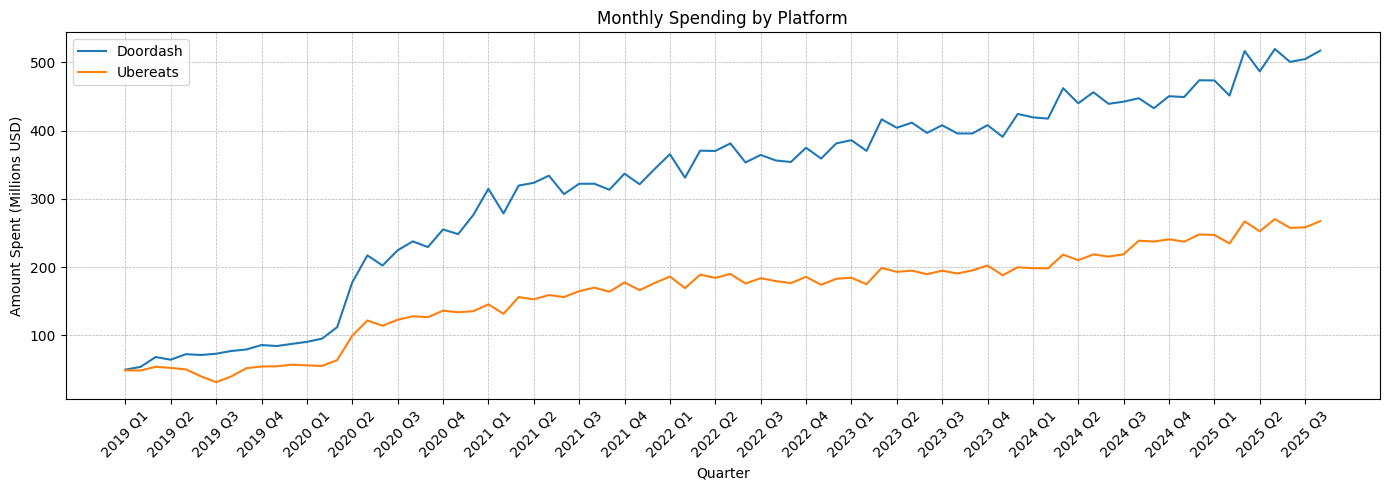

In [13]:
df_door = pd.read_excel("data/uberdash.xlsx", sheet_name="doordash")
df_uber = pd.read_excel("data/uberdash.xlsx", sheet_name="ubereats")

merged = pd.merge(df_door, df_uber, on="YYMM", suffixes=("_door","_uber"))

# mark the dec displays stuff? int cast
yymm = merged["YYMM"].astype(int)
merged["Year"] = (2000 + (yymm // 100)).astype(int)
merged["Month"] = (yymm % 100).astype(int)

# werid int cast succcessss rahh
def quarter_label(row):
    q = (row["Month"] - 1)//3 + 1
    return f"{int(row['Year'])} Q{int(q)}"

merged["Quarter"] = merged.apply(quarter_label, axis=1)
quarter_ticks = merged.drop_duplicates(["Year","Quarter"]).index
quarter_labels = merged.loc[quarter_ticks, "Quarter"].tolist()
x = merged.index





#plotty plot now
# dont need transactions
# fig1, ax1 = plt.subplots(figsize=(14,5))
# ax1.plot(x, merged["TRANS_COUNT_door"]/1e6, label="Doordash")
# ax1.plot(x, merged["TRANS_COUNT_uber"]/1e6, label="Ubereats")
# ax1.set_title("Monthly Transactions by Platform")
# ax1.set_ylabel("Transactions (Millions)")
# ax1.set_xlabel("Quarter")
# ax1.set_xticks(quarter_ticks)
# ax1.set_xticklabels(quarter_labels, rotation=45)
# ax1.grid(True, linestyle="--", linewidth=0.5)
# ax1.legend()
# plt.tight_layout()
# plt.show()

fig2, ax2 = plt.subplots(figsize=(14,5))
ax2.plot(x, merged["SPEND_AMOUNT_door"]/1e6, label="Doordash")
ax2.plot(x, merged["SPEND_AMOUNT_uber"]/1e6, label="Ubereats")
ax2.set_title("Monthly Spending by Platform")
ax2.set_ylabel("Amount Spent (Millions USD)")
ax2.set_xlabel("Quarter")
ax2.set_xticks(quarter_ticks)
ax2.set_xticklabels(quarter_labels, rotation=45)
ax2.grid(True, linestyle="--", linewidth=0.5)
ax2.legend()
plt.tight_layout()
plt.show()


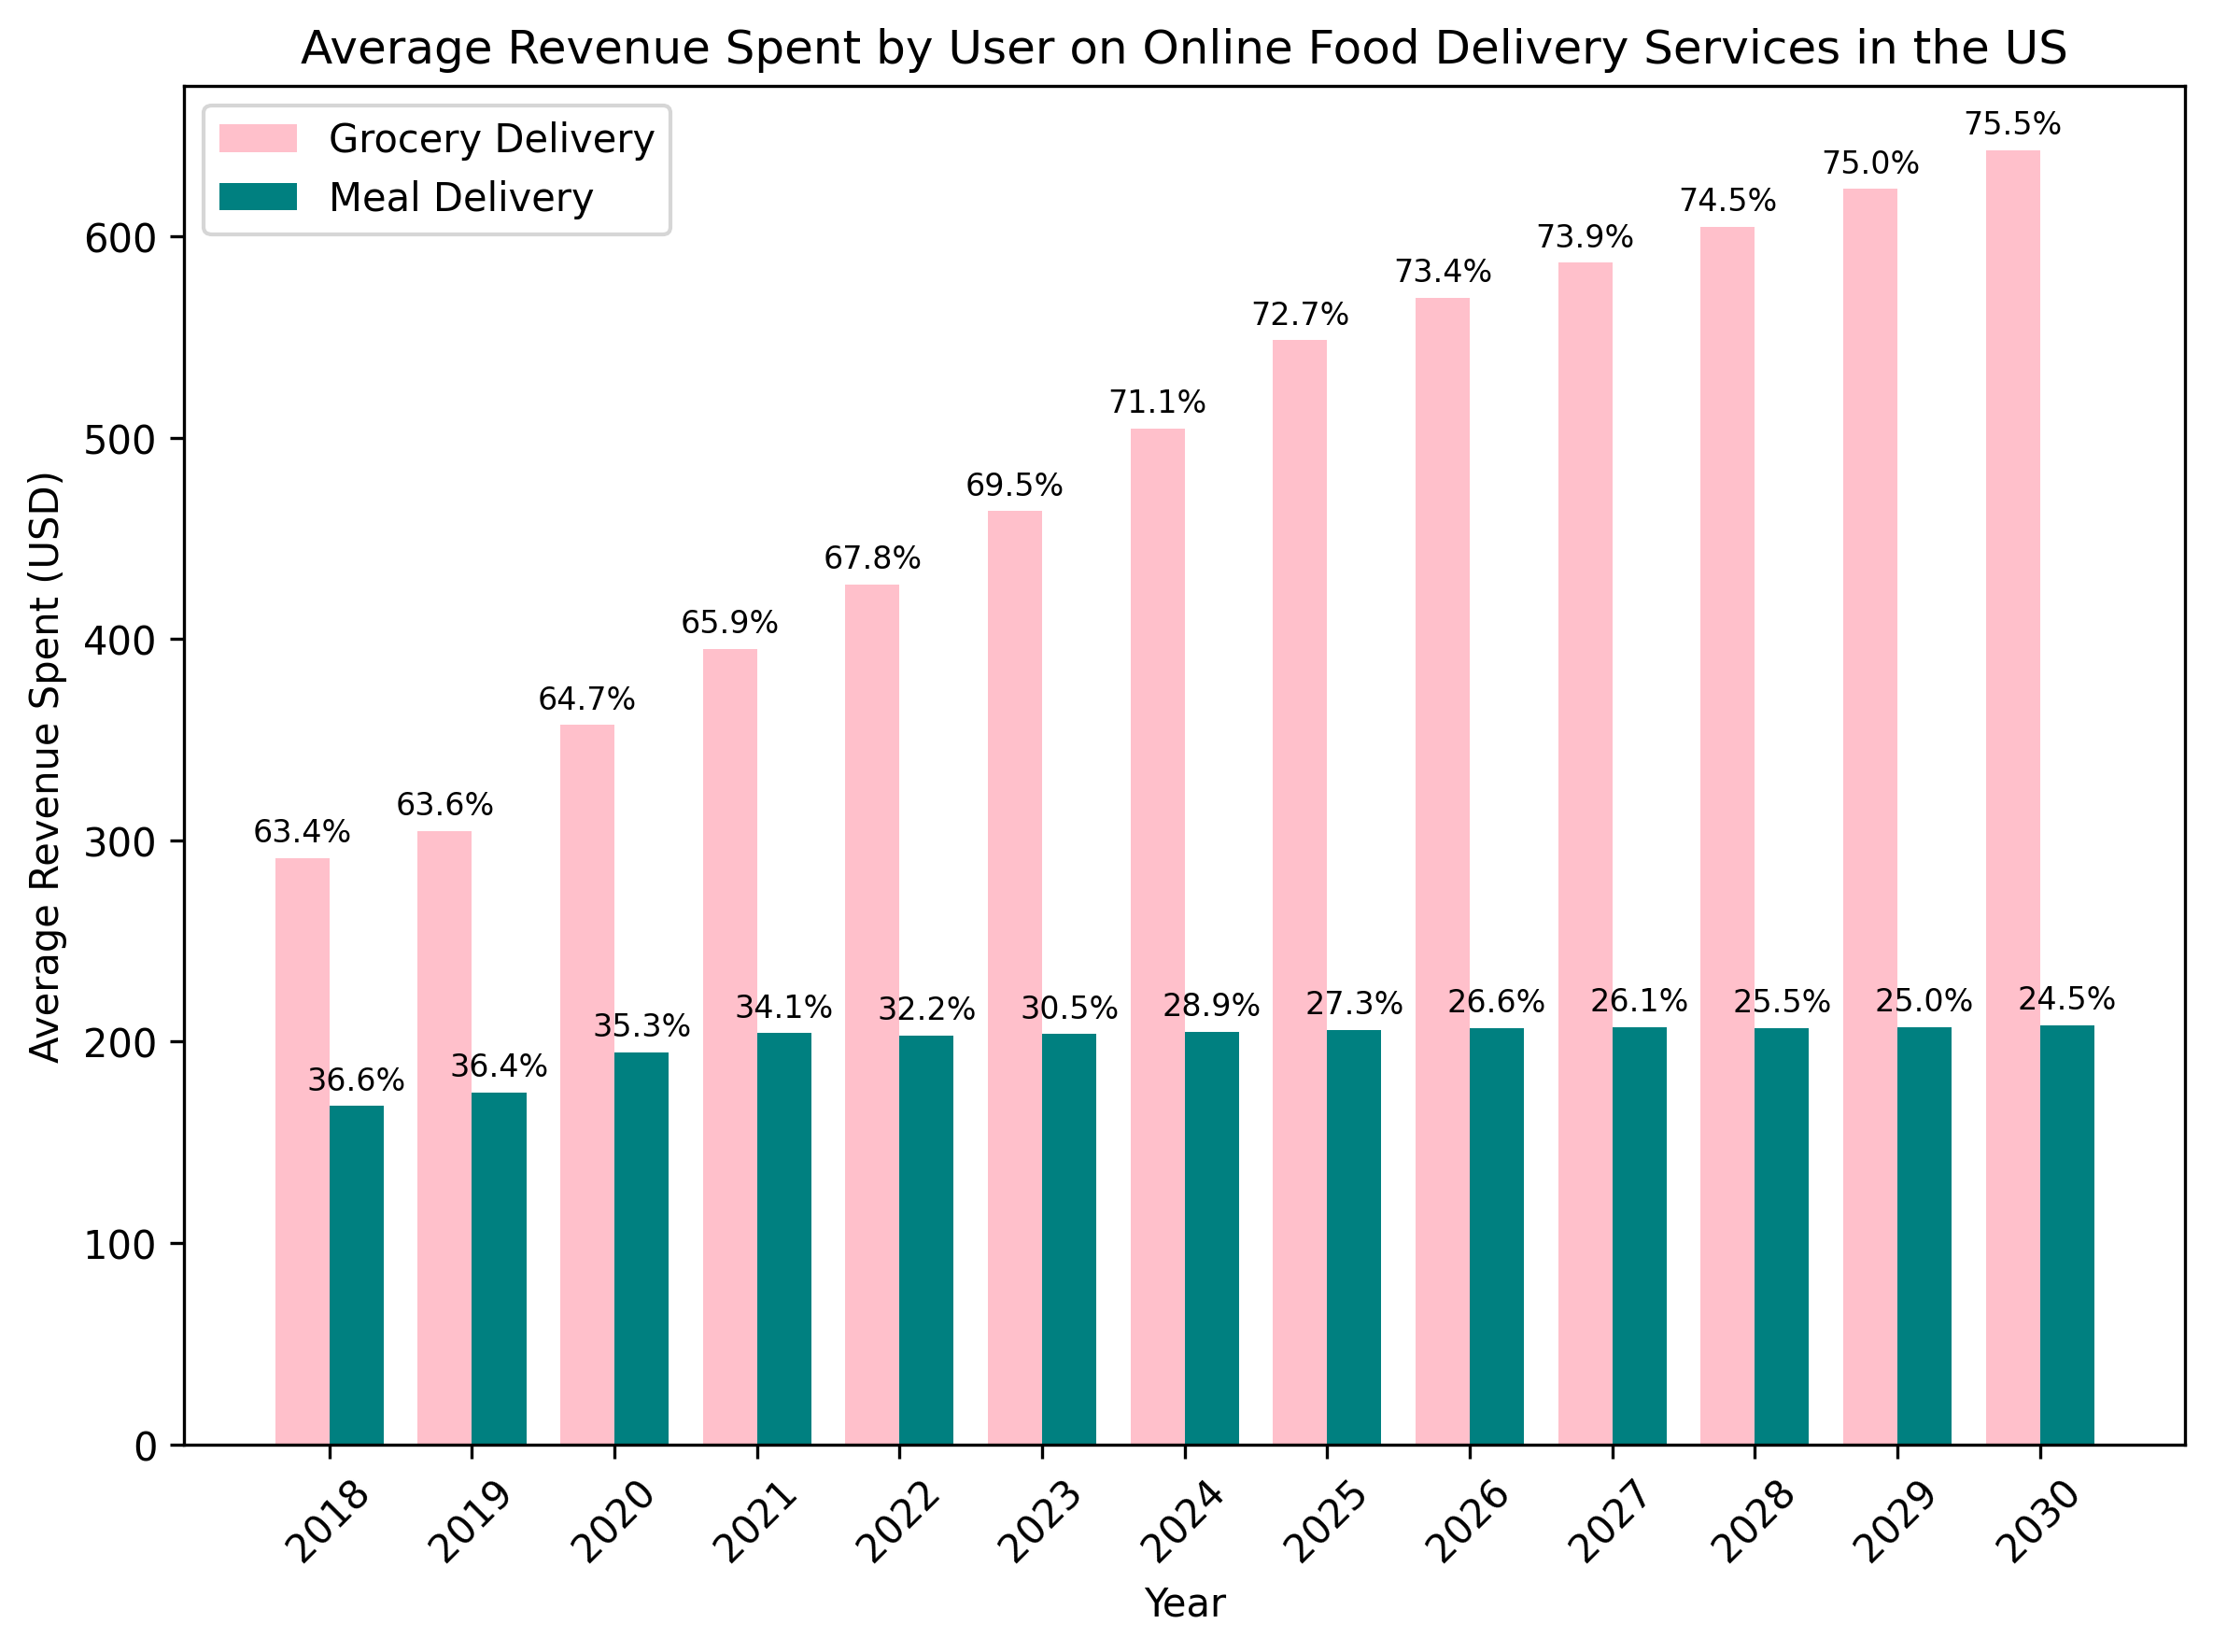

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

path = "data/ecommerce_online-food-delivery_worldwide_USD_en.xlsx"
df = pd.read_excel(path, sheet_name="S0", header=None)

arpu_rows = df.loc[3:, 4].dropna().index
years_arpu = df.loc[arpu_rows, 4].astype(int).to_numpy()
grocery_arpu = df.loc[arpu_rows, 5].astype(float).to_numpy()
meal_arpu = df.loc[arpu_rows, 6].astype(float).to_numpy()
totals = grocery_arpu + meal_arpu
grocery_pct = 100 * grocery_arpu / totals
meal_pct = 100 * meal_arpu / totals

x = np.arange(len(years_arpu))
width = 0.38 
plt.figure(figsize=(8,6), dpi=300)

# pastel time :)
c_meal = "#008080" 
c_grocery = "#FFC0CB"


plt.bar(x - width/2, grocery_arpu, width, color=c_grocery, label="Grocery Delivery")
plt.bar(x + width/2, meal_arpu,    width, color=c_meal,   label="Meal Delivery")

plt.xticks(x, years_arpu, rotation=45)
plt.xlabel("Year")
plt.ylabel("Average Revenue Spent (USD)")
plt.title("Average Revenue Spent by User on Online Food Delivery Services in the US")
plt.legend()

# percent stuff took a fat second but satisfying
for i in range(len(x)):

    plt.text(
        x[i] - width/2, 
        grocery_arpu[i] + 5,
        f"{grocery_pct[i]:.1f}%",
        ha="center",
        va="bottom",
        fontsize=8,
        color="black"
    )

    plt.text(
        x[i] + width/2, 
        meal_arpu[i] + 5,
        f"{meal_pct[i]:.1f}%",
        ha="center",
        va="bottom",
        fontsize=8,
        color="black"
    )

plt.tight_layout()
plt.show()


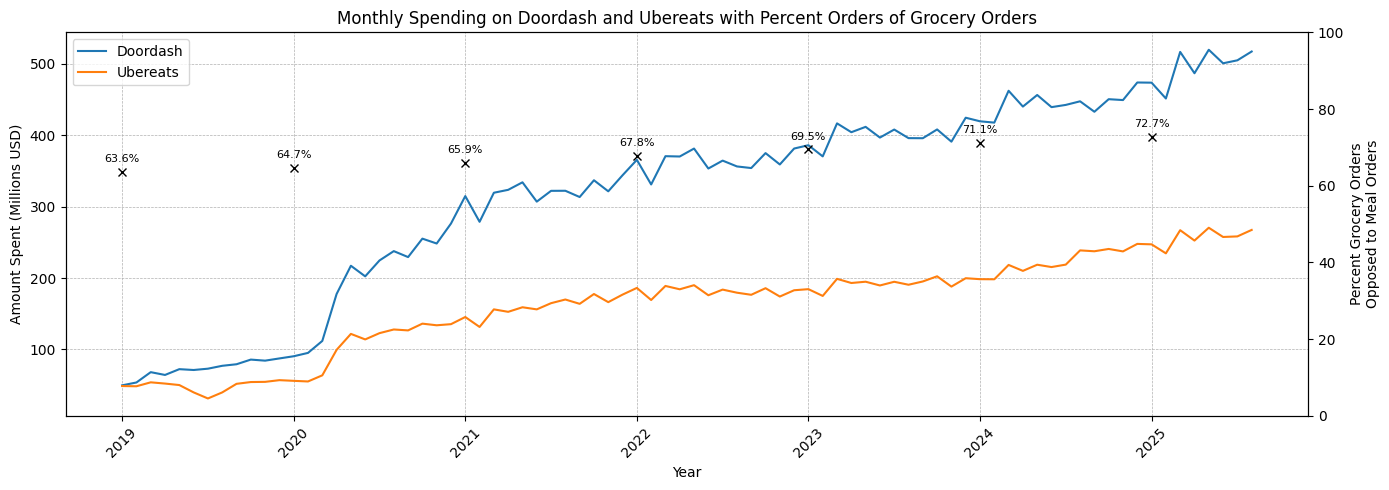

In [19]:
# grocery % tomfoolery
grocery_map = {int(y): float(p) for y, p in zip(years_arpu, grocery_pct)}

years_in_merged = sorted(merged["Year"].unique()) # one x-pos
year_positions = [merged.index[merged["Year"] == y][0] for y in years_in_merged]

grocery_vals = [grocery_map.get(int(y), np.nan) for y in years_in_merged]

# re-fig
fig3, ax3 = plt.subplots(figsize=(14, 5))
ax3.plot(merged.index, merged["SPEND_AMOUNT_door"] / 1e6, label="Doordash")
ax3.plot(merged.index, merged["SPEND_AMOUNT_uber"] / 1e6, label="Ubereats")
ax3.set_title("Monthly Spending on Doordash and Ubereats with Percent Orders of Grocery Orders")
ax3.set_ylabel("Amount Spent (Millions USD)")
ax3.set_xlabel("Year")

ax3.set_xticks(year_positions)
ax3.set_xticklabels(years_in_merged, rotation=45)
ax3.grid(True, linestyle="--", linewidth=0.5)
ax3.legend(loc="upper left")

axg = ax3.twinx()
axg.set_ylabel("Percent Grocery Orders\nOpposed to Meal Orders")
axg.set_ylim(0, 100)

# markers yay
axg.plot(year_positions, grocery_vals, marker="x", linestyle="none", color="black")

# marklab
for xpos, year, gpct in zip(year_positions, years_in_merged, grocery_vals):
    if np.isnan(gpct):
        continue
    axg.text(xpos, gpct + 2, f"{gpct:.1f}%", ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()
